In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from tqdm.auto import tqdm

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from trainer import Trainer

#%load_ext autoreload
#%autoreload 2

In [2]:
xmin = 300
xmax = 1620

ymin = 520
ymax = 864

height = ymax - ymin
width = xmax - xmin

scale = 0.2
scaled_width = int(scale*width)
scaled_height = int(scale*height)

def crop(img):
    return img[ymin:ymax, xmin:xmax, :]

def resize(img):
    return cv2.resize(img, dsize=(scaled_width, scaled_height), interpolation=cv2.INTER_LINEAR)

def normalise(img):
    return (img / 255)

def preprocess(img):
    img = crop(img)
    img = resize(img)
    img = normalise(img)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img)
    return img

def create_tensor(img):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    img_tensor = torch.FloatTensor(img).to(device).permute(2, 0, 1).unsqueeze(0)
    return img_tensor

In [3]:
# image_path = validset.image_paths[0]
# img = read_image(image_path)
# plt.imshow(img)

In [4]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

import os

# Simple helper data class that's a little nicer to use than a 2-tuple.
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

class TensorrtModel:
    def __init__(self, onnx_file_path):
        self.init_tensorrt(onnx_file_path)
        
    def predict(self, img):
        self.inputs[0].host = img
        out = self.do_inference_v2(self.context, self.bindings, self.inputs, self.outputs, self.stream)[0]
        if type(out) == np.ndarray:
            out = out[0]
        return out
    
    # Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
    def allocate_buffers(self, engine):
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()
        for binding in engine:
            size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            # Append the device buffer to device bindings.
            bindings.append(int(device_mem))
            # Append to the appropriate list.
            if engine.binding_is_input(binding):
                inputs.append(HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(HostDeviceMem(host_mem, device_mem))
        return inputs, outputs, bindings, stream

    # This function is generalized for multiple inputs/outputs for full dimension networks.
    # inputs and outputs are expected to be lists of HostDeviceMem objects.
    def do_inference_v2(self, context, bindings, inputs, outputs, stream):
        # Transfer input data to the GPU.
        [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
        # Run inference.
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer predictions back from the GPU.
        [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
        # Synchronize the stream
        stream.synchronize()
        # Return only the host outputs.
        return [out.host for out in outputs]

    def build_engine_from_onnx(self, onnx_file_path):
        """Takes an ONNX file and creates a TensorRT engine to run inference with"""
        EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
        with trt.Logger() as trt_logger, trt.Builder(trt_logger) as builder, builder.create_network(
                EXPLICIT_BATCH) as network, trt.OnnxParser(network, trt_logger) as parser:
            builder.max_workspace_size = 1 << 28  # 256MiB
            builder.max_batch_size = 1
            # Parse model file
            if not os.path.exists(onnx_file_path):
                print('ONNX file {} not found.'.format(onnx_file_path))
                exit(0)
            print('Loading ONNX file from path {}...'.format(onnx_file_path))
            with open(onnx_file_path, 'rb') as model:
                print('Beginning ONNX file parsing')
                if not parser.parse(model.read()):
                    print('ERROR: Failed to parse the ONNX file.')
                    for error in range(parser.num_errors):
                        print(parser.get_error(error))
                    return None
            # The actual yolov3.onnx is generated with batch size 64. Reshape input to batch size 1
            # network.get_input(0).shape = [1, 3, 128, 1024 ]
            print('Completed parsing of ONNX file')
            print('Building an engine from file {}; this may take a while...'.format(onnx_file_path))
            engine = builder.build_cuda_engine(network)
            print("Completed creating Engine")
            return engine

    def init_tensorrt(self, onnx_file_path):
        engine = self.build_engine_from_onnx(onnx_file_path)
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers(engine)
        self.context = engine.create_execution_context()

In [5]:
model_path = "models/1-pilotnet-base/wide-v2"
tensorrt_model = TensorrtModel(f"{model_path}/best.onnx")

Loading ONNX file from path models/1-pilotnet-base/wide-v2/best.onnx...
Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine from file models/1-pilotnet-base/wide-v2/best.onnx; this may take a while...
Completed creating Engine


In [6]:
root_path = Path("/home/romet/data/datasets/ut/nvidia-data")
valid_paths = [root_path / "2021-06-07-14-20-07_e2e_rec_ss6"]
validset = NvidiaDataset(valid_paths, camera="front_wide")

In [7]:
tensorrt_predictions = []

for path in tqdm(validset.image_paths):
    img = read_image(path)
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = np.array(img, dtype=np.float32, order='C')
    prediction = tensorrt_model.predict(img)
    tensorrt_predictions.append(prediction)

  0%|          | 0/25804 [00:00<?, ?it/s]

In [8]:
trainer = Trainer("")
torch_model = trainer.load_model(f"{model_path}/best.pt")
torch_model.eval()

PilotNet(
  (features): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Flatten(st

In [9]:
torch_predictions = []

for path in tqdm(validset.image_paths):
    img = read_image(path)
    img_tensor = create_tensor(img)
    prediction = torch_model(img_tensor).squeeze(1)
    torch_predictions.append(prediction.item())

  0%|          | 0/25804 [00:00<?, ?it/s]

In [10]:
tr = transforms.Compose([NvidiaCropWide(), Normalize()])
validset_tr = NvidiaDataset(valid_paths, tr)
torch_transforms_predictions = trainer.predict(torch_model, validset_tr)

  0%|          | 0/404 [00:00<?, ?it/s]

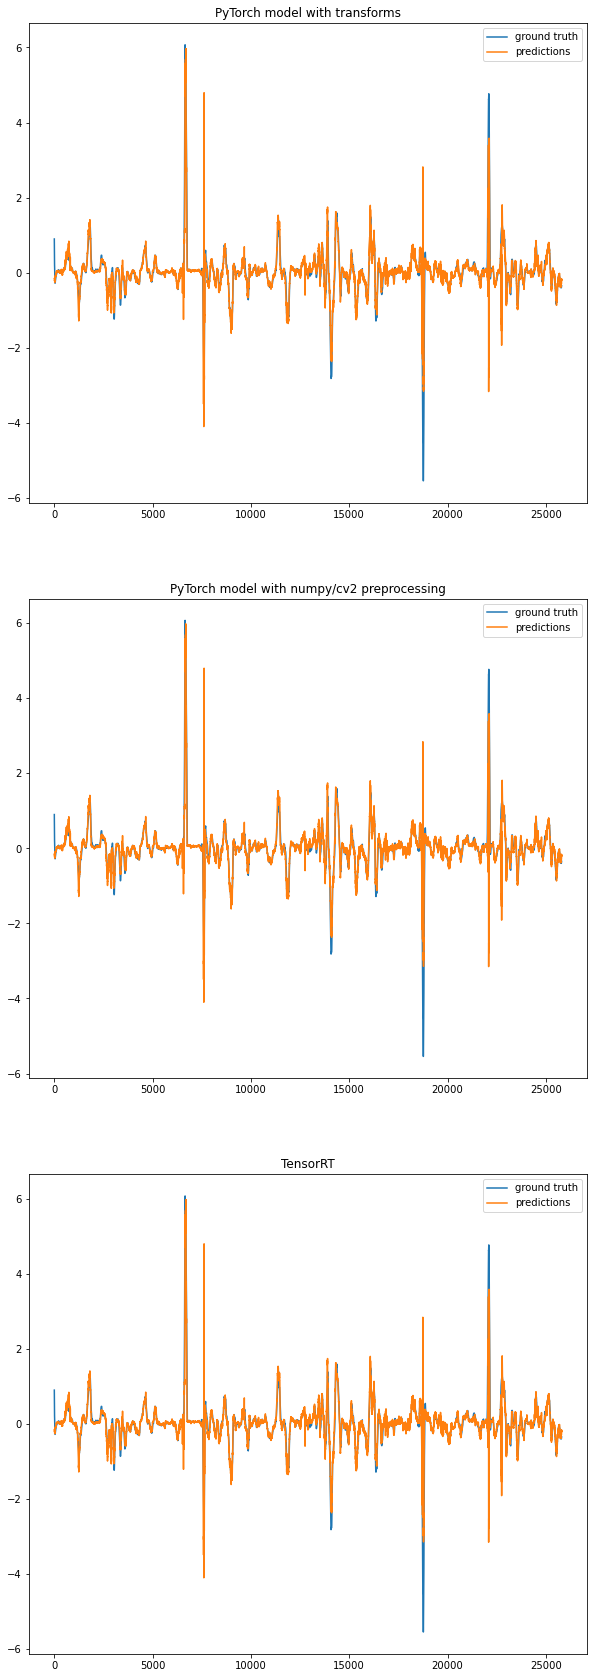

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

ax1.plot(validset.steering_angles)
ax1.plot(torch_transforms_predictions)
ax1.legend(["ground truth", "predictions"])
ax1.set_title("PyTorch model with transforms")

ax2.plot(validset.steering_angles)
ax2.plot(torch_predictions)
ax2.legend(["ground truth", "predictions"])
ax2.set_title("PyTorch model with numpy/cv2 preprocessing")

ax3.plot(validset.steering_angles)
ax3.plot(tensorrt_predictions)
ax3.legend(["ground truth", "predictions"])
ax3.set_title("TensorRT");

In [12]:
import math
import cv2
import shutil
from skimage import io
import os
from moviepy.editor import ImageSequenceClip


def draw_steering_angle(frame, steering_angle, steering_wheel_radius, steering_position, size, color):
    steering_angle_rad = math.radians(steering_angle)
    x = steering_wheel_radius * np.cos(np.pi / 2 + steering_angle_rad)
    y = steering_wheel_radius * np.sin(np.pi / 2 + steering_angle_rad)
    cv2.circle(frame, (steering_position[0] + int(x), steering_position[1] - int(y)), size, color, thickness=-1)
    
def draw_frames(dataset, predicted_angles, temp_frames_folder):
    
    for frame_index, data in tqdm(enumerate(dataset), total=len(dataset)):
        frame = data["image"].permute(1, 2, 0).cpu().numpy()
        true_angle = math.degrees(data["steering_angle"])
        pred_angle = math.degrees(predicted_angles[frame_index])
        
        cv2.putText(frame, 'True: {:.2f}deg'.format(true_angle), (10, 1150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2,
                    cv2.LINE_AA)
        cv2.putText(frame, 'Pred: {:.2f}deg'.format(pred_angle), (10, 1200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2,
                    cv2.LINE_AA)
    
        radius = 200
        steering_pos = (960, 1200)
        cv2.circle(frame, steering_pos, radius, (255, 255, 255), 7)

        draw_steering_angle(frame, true_angle, radius, steering_pos, 13, (0, 255, 0))
        draw_steering_angle(frame, pred_angle, radius, steering_pos, 9, (255, 0, 0))
            
        io.imsave(f"{temp_frames_folder}/{frame_index + 1:05}.jpg", frame)
        

def convert_frames_to_video(frames_folder, output_video_path, fps=25):
    output_folder = Path(os.path.split(output_video_path)[:-1][0])
    output_folder.mkdir(parents=True, exist_ok=True)

    p = Path(frames_folder).glob('**/*.jpg')
    image_list = sorted([str(x) for x in p if x.is_file()])

    print("Creating video {}, FPS={}".format(frames_folder, fps))
    clip = ImageSequenceClip(image_list, fps=fps)
    clip.write_videofile(output_video_path)


In [13]:
temp_frames_folder = Path("./temp_frames")
shutil.rmtree(temp_frames_folder, ignore_errors=True)
temp_frames_folder.mkdir()

draw_frames(validset, tensorrt_predictions, temp_frames_folder)
output_video = "output/wide-v2-ss6.mp4"
convert_frames_to_video(temp_frames_folder, output_video, fps=30.0)

shutil.rmtree(temp_frames_folder, ignore_errors=True)

  0%|          | 0/25804 [00:00<?, ?it/s]

Creating video temp_frames, FPS=30.0
Moviepy - Building video output/wide-v2-ss4.mp4.
Moviepy - Writing video output/wide-v2-ss4.mp4




t:   1%|          | 180/25804 [00:36<1:40:56,  4.23it/s, now=None]


t:   1%|          | 319/25804 [01:11<1:28:17,  4.81it/s, now=None]


t:   2%|▏         | 463/25804 [01:49<1:21:01,  5.21it/s, now=None]


t:   2%|▏         | 610/25804 [02:21<1:42:36,  4.09it/s, now=None]


t:   3%|▎         | 759/25804 [02:57<2:52:26,  2.42it/s, now=None]


t:   4%|▍         | 971/25804 [03:21<28:59, 14.27it/s, now=None]


t:   5%|▍         | 1207/25804 [03:40<35:24, 11.58it/s, now=None]


t:   6%|▌         | 1442/25804 [04:01<37:35, 10.80it/s, now=None]


t:   6%|▋         | 1677/25804 [04:18<32:55, 12.21it/s, now=None]


t:   7%|▋         | 1914/25804 [04:35<30:49, 12.92it/s, now=None]


t:   8%|▊         | 2160/25804 [04:51<27:04, 14.55it/s, now=None]


t:   9%|▉         | 2398/25804 [05:09<34:46, 11.22it/s, now=None]


t:  10%|█         | 2636/25804 [05:25<29:47, 12.96it/s, now=None]


t:  11%|█         | 2875/25804 [05:44<29:47, 12.83it/s, now=None]


t:  12%|█▏        | 3113/25804 [06:04<31:31, 12.00it/s, now=None]


t:  13%|█▎        | 3350/25804 [06:21<25:54, 14.44it/s, now=None]


t:  14%|█▍        | 3587/25804 [06:39<24:55, 14.86it/s, now=None]


t:  15%|█▍        | 3823/25804 [06:58<38:14,  9.58it/s, now=None]


t:  16%|█▌        | 4038/25804 [07:20<33:08, 10.94it/s, now=None]


t:  17%|█▋        | 4280/25804 [07:36<22:08, 16.20it/s, now=None]


t:  18%|█▊        | 4519/25804 [07:52<25:34, 13.87it/s, now=None]


t:  18%|█▊        | 4760/25804 [08:09<24:47, 14.15it/s, now=None]


t:  19%|█▉        | 5003/25804 [08:25<20:56, 16.56it/s, now=None]


t:  20%|██        | 5250/25804 [08:40<23:37, 14.50it/s, now=None]


t:  21%|██▏       | 5494/25804 [08:56<19:27, 17.40it/s, now=None]


t:  22%|██▏       | 5732/25804 [09:13<21:28, 15.58it/s, now=None]


t:  23%|██▎       | 5970/25804 [09:30<26:16, 12.58it/s, now=None]


t:  24%|██▍       | 6206/25804 [09:48<22:00, 14.84it/s, now=None]


t:  25%|██▍       | 6444/25804 [10:08<24:12, 13.33it/s, now=None]


t:  26%|██▌       | 6687/25804 [10:26<16:19, 19.51it/s, now=None]


t:  27%|██▋       | 6932/25804 [10:41<21:50, 14.40it/s, now=None]


t:  28%|██▊       | 7168/25804 [10:58<22:58, 13.52it/s, now=None]


t:  29%|██▊       | 7410/25804 [11:15<19:44, 15.53it/s, now=None]


t:  30%|██▉       | 7649/25804 [11:32<20:44, 14.58it/s, now=None]


t:  31%|███       | 7886/25804 [11:51<25:36, 11.66it/s, now=None]


t:  31%|███▏      | 8122/25804 [12:08<19:11, 15.36it/s, now=None]


t:  32%|███▏      | 8358/25804 [12:27<25:12, 11.53it/s, now=None]


t:  33%|███▎      | 8595/25804 [12:46<20:38, 13.90it/s, now=None]


t:  34%|███▍      | 8832/25804 [13:06<22:59, 12.30it/s, now=None]


t:  35%|███▌      | 9070/25804 [13:23<19:00, 14.67it/s, now=None]


t:  36%|███▌      | 9306/25804 [13:41<23:47, 11.56it/s, now=None]


t:  37%|███▋      | 9544/25804 [14:00<17:46, 15.25it/s, now=None]


t:  38%|███▊      | 9782/25804 [14:18<19:32, 13.67it/s, now=None]


t:  39%|███▉      | 10022/25804 [14:37<15:10, 17.33it/s, now=None]


t:  40%|███▉      | 10262/25804 [14:53<15:27, 16.75it/s, now=None]


t:  41%|████      | 10509/25804 [15:08<14:46, 17.26it/s, now=None]


t:  42%|████▏     | 10749/25804 [15:24<17:03, 14.70it/s, now=None]


t:  43%|████▎     | 10990/25804 [15:40<17:33, 14.06it/s, now=None]


t:  44%|████▎     | 11235/25804 [15:55<14:01, 17.31it/s, now=None]


t:  44%|████▍     | 11479/25804 [16:10<16:26, 14.51it/s, now=None]


t:  45%|████▌     | 11715/25804 [16:26<16:28, 14.25it/s, now=None]


t:  46%|████▋     | 11952/25804 [16:42<13:57, 16.54it/s, now=None]


t:  47%|████▋     | 12197/25804 [16:58<12:20, 18.37it/s, now=None]


t:  48%|████▊     | 12435/25804 [17:14<13:26, 16.58it/s, now=None]


t:  49%|████▉     | 12677/25804 [17:29<16:19, 13.40it/s, now=None]


t:  50%|█████     | 12914/25804 [17:48<16:08, 13.31it/s, now=None]


t:  51%|█████     | 13147/25804 [18:07<13:35, 15.51it/s, now=None]


t:  52%|█████▏    | 13381/25804 [18:26<14:23, 14.38it/s, now=None]


t:  53%|█████▎    | 13616/25804 [18:47<15:01, 13.53it/s, now=None]


t:  54%|█████▎    | 13850/25804 [19:07<19:08, 10.41it/s, now=None]


t:  55%|█████▍    | 14084/25804 [19:25<13:30, 14.47it/s, now=None]


t:  55%|█████▌    | 14300/25804 [19:47<13:39, 14.03it/s, now=None]


t:  56%|█████▋    | 14540/25804 [20:03<13:08, 14.29it/s, now=None]


t:  57%|█████▋    | 14777/25804 [20:20<13:31, 13.59it/s, now=None]


t:  58%|█████▊    | 15011/25804 [20:40<20:01,  8.98it/s, now=None]


t:  59%|█████▉    | 15245/25804 [20:58<13:16, 13.25it/s, now=None]


t:  60%|█████▉    | 15479/25804 [21:17<12:49, 13.42it/s, now=None]


t:  61%|██████    | 15713/25804 [21:35<11:40, 14.41it/s, now=None]


t:  62%|██████▏   | 15948/25804 [21:52<10:49, 15.17it/s, now=None]


t:  63%|██████▎   | 16186/25804 [22:08<10:48, 14.84it/s, now=None]


t:  64%|██████▎   | 16421/25804 [22:26<10:04, 15.51it/s, now=None]


t:  65%|██████▍   | 16663/25804 [22:42<09:43, 15.67it/s, now=None]


t:  65%|██████▌   | 16899/25804 [22:59<12:05, 12.27it/s, now=None]


t:  66%|██████▋   | 17133/25804 [23:16<10:43, 13.47it/s, now=None]


t:  67%|██████▋   | 17367/25804 [23:34<10:55, 12.87it/s, now=None]


t:  68%|██████▊   | 17602/25804 [23:52<10:29, 13.03it/s, now=None]


t:  69%|██████▉   | 17836/25804 [24:10<10:43, 12.39it/s, now=None]


t:  70%|███████   | 18070/25804 [24:29<12:38, 10.20it/s, now=None]


t:  71%|███████   | 18304/25804 [24:47<09:52, 12.66it/s, now=None]


t:  72%|███████▏  | 18539/25804 [25:03<12:05, 10.01it/s, now=None]


t:  73%|███████▎  | 18776/25804 [25:21<06:26, 18.20it/s, now=None]


t:  74%|███████▎  | 19021/25804 [25:36<06:58, 16.20it/s, now=None]


t:  75%|███████▍  | 19256/25804 [25:53<07:55, 13.78it/s, now=None]


t:  76%|███████▌  | 19492/25804 [26:11<08:49, 11.91it/s, now=None]


t:  76%|███████▋  | 19726/25804 [26:31<10:16,  9.85it/s, now=None]


t:  77%|███████▋  | 19959/25804 [26:50<06:02, 16.13it/s, now=None]


t:  78%|███████▊  | 20202/25804 [27:05<05:35, 16.71it/s, now=None]


t:  79%|███████▉  | 20437/25804 [27:21<06:09, 14.51it/s, now=None]


t:  80%|████████  | 20675/25804 [27:36<05:19, 16.05it/s, now=None]


t:  81%|████████  | 20916/25804 [27:51<04:25, 18.38it/s, now=None]


t:  82%|████████▏ | 21185/25804 [28:06<03:47, 20.30it/s, now=None]


t:  83%|████████▎ | 21457/25804 [28:21<04:02, 17.95it/s, now=None]


t:  84%|████████▍ | 21718/25804 [28:35<04:20, 15.67it/s, now=None]


t:  85%|████████▌ | 21954/25804 [28:51<04:25, 14.51it/s, now=None]


t:  86%|████████▌ | 22202/25804 [29:07<04:03, 14.80it/s, now=None]


t:  87%|████████▋ | 22446/25804 [29:22<03:28, 16.11it/s, now=None]


t:  88%|████████▊ | 22684/25804 [29:38<03:02, 17.11it/s, now=None]


t:  89%|████████▉ | 22921/25804 [29:53<03:04, 15.61it/s, now=None]


t:  90%|████████▉ | 23157/25804 [30:09<03:30, 12.60it/s, now=None]


t:  91%|█████████ | 23402/25804 [30:25<02:45, 14.52it/s, now=None]


t:  92%|█████████▏| 23646/25804 [30:40<02:00, 17.94it/s, now=None]


t:  93%|█████████▎| 23901/25804 [30:55<01:45, 18.04it/s, now=None]


t:  94%|█████████▎| 24178/25804 [31:10<01:32, 17.66it/s, now=None]


t:  95%|█████████▍| 24453/25804 [31:25<01:14, 18.25it/s, now=None]


t:  96%|█████████▌| 24701/25804 [31:40<01:16, 14.40it/s, now=None]


t:  97%|█████████▋| 24946/25804 [31:55<00:53, 15.90it/s, now=None]


t:  98%|█████████▊| 25181/25804 [32:12<00:44, 13.94it/s, now=None]


t:  98%|█████████▊| 25416/25804 [32:29<00:28, 13.56it/s, now=None]


t:  99%|█████████▉| 25650/25804 [32:48<00:12, 12.22it/s, now=None]


t: 100%|█████████▉| 25803/25804 [33:00<00:00, 13.61it/s, now=None]
                                                                  

Moviepy - Done !
Moviepy - video ready output/wide-v2-ss4.mp4


In [14]:
from IPython.display import HTML


HTML(f"""
<video width="640" height="480" controls>
  <source src="{output_video}" type="video/mp4">
</video>
""")

In [15]:
output_video

'output/wide-v2-ss4.mp4'